In [3]:
# ============================
# Simplified paper replication
# Strategy-embedded loss + PBWA weighting
# Using free OHLCV from yfinance
# ============================

import os
import math
import random
import numpy as np
import pandas as pd

import yfinance as yf

import torch
import torch.nn as nn
from torch.optim import Adam

# ----------------------------
# Reproducibility
# ----------------------------
def set_seeds(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seeds(42)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ----------------------------
# Universe: S&P500 tickers (free)
# ----------------------------

def load_sp500_tickers_yf():
    t = yf.Ticker("^GSPC")
    tickers = list(t.constituents.keys()) if getattr(t, "constituents", None) else None
    if not tickers:
        raise RuntimeError("yfinance constituents not available in your version.")
    return [x.replace(".", "-") for x in tickers]


# ----------------------------
# Data download (OHLCV)
# ----------------------------
def download_ohlcv(tickers, start="2010-01-01", end="2024-12-31", auto_adjust=False):
    """
    Returns: dict with keys Open, High, Low, Close, Volume as DataFrames [date x ticker]
    yfinance can be flaky; download in chunks.
    """
    if end is None:
        end = pd.Timestamp.today().strftime("%Y-%m-%d")

    chunks = []
    chunk_size = 100
    for i in range(0, len(tickers), chunk_size):
        chunks.append(tickers[i:i+chunk_size])

    frames = []
    for ch in chunks:
        data = yf.download(
            ch, start=start, end=end, auto_adjust=auto_adjust,
            group_by="column", threads=True, progress=False
        )
        # If multiple tickers, columns are MultiIndex: (field, ticker)
        if isinstance(data.columns, pd.MultiIndex):
            frames.append(data)
        else:
            # single ticker edge case
            data.columns = pd.MultiIndex.from_product([data.columns, ch])
            frames.append(data)

    data = pd.concat(frames, axis=1).sort_index()
    out = {}
    for field in ["Open", "High", "Low", "Close", "Volume"]:
        out[field] = data[field].copy()
    return out

# ----------------------------
# Features (all shifted by 1 day)
# ----------------------------
def rsi(close: pd.DataFrame, window: int = 14):
    delta = close.diff()
    up = delta.clip(lower=0)
    down = (-delta).clip(lower=0)
    roll_up = up.rolling(window, min_periods=window).mean()
    roll_down = down.rolling(window, min_periods=window).mean()
    rs = roll_up / (roll_down + 1e-12)
    return 100 - (100 / (1 + rs))

def make_features(data):
    """
    data: dict Open/Close/Volume DF
    returns: features panel (date x ticker x feature), labels (date x ticker)
    """
    close = data["Close"]
    open_ = data["Open"]
    volu = data["Volume"]

    # Label: open->close return for day t (what we trade)
    y = (close / open_) - 1.0

    # Basic returns for feature engineering (close-to-close)
    cc = close.pct_change()

    # Momentum / reversal
    mom20 = close / close.shift(20) - 1
    mom60 = close / close.shift(60) - 1
    mom252 = close / close.shift(252) - 1
    rev5 = close / close.shift(5) - 1

    # Volatility
    vol20 = cc.rolling(20, min_periods=20).std(ddof=0)

    # MA ratios
    ma20 = close.rolling(20, min_periods=20).mean()
    ma60 = close.rolling(60, min_periods=60).mean()
    prc_ma20 = close / (ma20 + 1e-12) - 1
    prc_ma60 = close / (ma60 + 1e-12) - 1

    # Volume z-score
    vma20 = volu.rolling(20, min_periods=20).mean()
    vsd20 = volu.rolling(20, min_periods=20).std(ddof=0)
    volz20 = (volu - vma20) / (vsd20 + 1e-12)

    # RSI
    rsi14 = rsi(close, 14) / 100.0  # scale to [0,1]

    feats = {
        "mom20": mom20,
        "mom60": mom60,
        "mom252": mom252,
        "rev5": rev5,
        "vol20": vol20,
        "prc_ma20": prc_ma20,
        "prc_ma60": prc_ma60,
        "volz20": volz20,
        "rsi14": rsi14,
    }

    # Shift ALL features by 1 day to ensure they're known at time of trading (today open)
    feats = {k: v.shift(1) for k, v in feats.items()}

    return feats, y

# ----------------------------
# Liquidity filter (avg dollar volume)
# ----------------------------
def liquid_universe(data, tickers, top_n=200, window=60):
    close = data["Close"][tickers]
    volu = data["Volume"][tickers]
    dolv = (close * volu).rolling(window, min_periods=window).mean()
    # Choose tickers with highest average dolv over entire sample (simple)
    score = dolv.mean().sort_values(ascending=False)
    return score.head(top_n).index.tolist()

# ----------------------------
# Build day-batches of sequences
# ----------------------------
def build_day_batches(feats_dict, y, tickers, seq_len=20, start_date=None, end_date=None):
    """
    For each date t, we create X: [n_stocks, seq_len, n_features], Y: [n_stocks]
    Sequences are constructed from shifted features, so they end at t (feature at t uses info up to t-1).
    """
    feat_names = list(feats_dict.keys())
    dates = y.index

    if start_date is not None:
        dates = dates[dates >= pd.to_datetime(start_date)]
    if end_date is not None:
        dates = dates[dates <= pd.to_datetime(end_date)]

    # Stack features into (date x ticker x feat)
    # We'll keep in pandas for alignment then convert per day.
    F = []
    for fn in feat_names:
        df = feats_dict[fn][tickers]
        F.append(df)
    # shape: list of DFs
    # We'll fetch rolling windows per ticker per day.
    # Efficient enough for ~200 tickers, ~3000 days.

    batches = []
    for t in dates:
        # Need seq_len rows ending at t
        idx_pos = y.index.get_loc(t)
        if idx_pos < seq_len:
            continue
        window_dates = y.index[idx_pos - seq_len + 1 : idx_pos + 1]

        # Build X for all tickers: [n, seq_len, f]
        X_list = []
        for fn in feat_names:
            X_list.append(feats_dict[fn].loc[window_dates, tickers].values[:, :])
        X = np.stack(X_list, axis=-1)  # [seq_len, n, f]
        X = np.transpose(X, (1, 0, 2)) # [n, seq_len, f]

        Y = y.loc[t, tickers].values  # [n]

        # Drop tickers with any NaNs in sequence or label
        mask = np.isfinite(Y)
        mask &= np.isfinite(X).all(axis=(1, 2))
        if mask.sum() < 20:
            continue

        batches.append((t, X[mask], Y[mask]))

    return batches, feat_names

def build_day_batches(feats_dict, y, tickers, seq_len=20, start_date=None, end_date=None):
    feat_names = list(feats_dict.keys())
    dates = y.index
    if start_date is not None:
        dates = dates[dates >= pd.to_datetime(start_date)]
    if end_date is not None:
        dates = dates[dates <= pd.to_datetime(end_date)]

    batches = []
    for t in dates:
        idx_pos = y.index.get_loc(t)
        if idx_pos < seq_len:
            continue
        window_dates = y.index[idx_pos - seq_len + 1 : idx_pos + 1]

        X_list = []
        for fn in feat_names:
            X_list.append(feats_dict[fn].loc[window_dates, tickers].values)
        X = np.stack(X_list, axis=-1)       # [seq_len, n, f]
        X = np.transpose(X, (1, 0, 2))      # [n, seq_len, f]
        Y = y.loc[t, tickers].values        # [n]

        mask = np.isfinite(Y) & np.isfinite(X).all(axis=(1,2))
        if mask.sum() < 20:
            continue

        tickers_masked = np.array(tickers)[mask].tolist()
        batches.append((t, X[mask], Y[mask], tickers_masked))

    return batches, feat_names


# ----------------------------
# Model: LSTM -> scalar return
# ----------------------------
class LSTMAlpha(nn.Module):
    def __init__(self, n_features, hidden=32, num_layers=1, dropout=0.0):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.head = nn.Sequential(
            nn.LayerNorm(hidden),
            nn.Linear(hidden, 1),
        )

    def forward(self, x):
        # x: [batch=n_stocks, seq_len, n_features]
        out, _ = self.lstm(x)
        last = out[:, -1, :]          # last step
        pred = self.head(last).squeeze(-1)
        return pred

# ----------------------------
# PBWA weights (PyTorch)
# ----------------------------
def pbwa_weights(pred, gamma=0.0, max_w=0.02, eps=1e-12):
    """
    pred: [n]
    returns weights [n], long-only.
    """
    raw = torch.relu(pred - gamma)
    s = raw.sum()
    if s.item() <= eps:
        # fallback: no signal -> all zeros (cash)
        return torch.zeros_like(raw)

    w = raw / (s + eps)

    # hard cap + renorm (subgrad ok)
    w = torch.clamp(w, max=max_w)
    if w.sum().item() <= eps:
        return torch.zeros_like(w)
    w = w / (w.sum() + eps)
    return w

# ----------------------------
# Train (one day = one batch)
# Strategy-embedded objective
# ----------------------------
def train_model(
    batches_train,
    batches_val,
    n_features,
    lam=0.5,
    k_turn=0.1,
    k_conc=0.1,
    gamma=0.0,
    max_w=0.02,
    lr=1e-3,
    epochs=5,
):
    model = LSTMAlpha(n_features=n_features, hidden=64).to(DEVICE)
    opt = Adam(model.parameters(), lr=lr)

    best_val = -np.inf
    best_state = None

    for ep in range(1, epochs + 1):
        model.train()
        prev_w = None
        tr_pnl, tr_mse = [], []

        # ✅ NOW UNPACK 4 VALUES
        for (dt, X_np, Y_np, tks) in batches_train:
            X = torch.tensor(X_np, dtype=torch.float32, device=DEVICE)
            Y = torch.tensor(Y_np, dtype=torch.float32, device=DEVICE)

            pred = model(X)
            mse = torch.mean((pred - Y) ** 2)

            w = pbwa_weights(pred, gamma=gamma, max_w=max_w)
            pnl = torch.sum(w * Y)

            conc = torch.sum(w ** 2)
            if prev_w is None:
                turn = torch.tensor(0.0, device=DEVICE)
            else:
                # if shapes differ (due to masking), skip turnover penalty for that step
                if prev_w.shape == w.shape:
                    turn = torch.sum(torch.abs(w - prev_w))
                else:
                    turn = torch.tensor(0.0, device=DEVICE)

            loss = mse - lam * pnl + k_turn * turn + k_conc * conc

            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            opt.step()

            prev_w = w.detach()

            tr_pnl.append(float(pnl.detach().cpu().item()))
            tr_mse.append(float(mse.detach().cpu().item()))

        # Validation
        model.eval()
        with torch.no_grad():
            val_pnl, val_mse = [], []

            # ✅ NOW UNPACK 4 VALUES
            for (dt, X_np, Y_np, tks) in batches_val:
                X = torch.tensor(X_np, dtype=torch.float32, device=DEVICE)
                Y = torch.tensor(Y_np, dtype=torch.float32, device=DEVICE)
                pred = model(X)

                mse = torch.mean((pred - Y) ** 2)
                w = pbwa_weights(pred, gamma=gamma, max_w=max_w)
                pnl = torch.sum(w * Y)

                val_pnl.append(float(pnl.cpu().item()))
                val_mse.append(float(mse.cpu().item()))

        val_score = float(np.mean(val_pnl)) if len(val_pnl) else -np.inf
        if val_score > best_val:
            best_val = val_score
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

        print(
            f"Epoch {ep:02d} | train pnl {np.mean(tr_pnl):+.6f} | train mse {np.mean(tr_mse):.6f} "
            f"| val pnl {np.mean(val_pnl):+.6f} | val mse {np.mean(val_mse):.6f}"
        )

    if best_state is not None:
        model.load_state_dict(best_state)
    return model


# ----------------------------
# Backtest on batches (with costs)
# ----------------------------
def backtest_batches(model, batches, tc_bps_per_side=10.0, slip_bps=5.0, gamma=0.0, max_w=0.02):
    model.eval()
    cost_rate = (tc_bps_per_side + slip_bps) / 1e4

    dates = []
    gross = []
    net = []
    turnover = []

    prev_w = None

    with torch.no_grad():
        for (dt, X_np, Y_np) in batches:
            X = torch.tensor(X_np, dtype=torch.float32, device=DEVICE)
            Y = torch.tensor(Y_np, dtype=torch.float32, device=DEVICE)
            pred = model(X)
            w = pbwa_weights(pred, gamma=gamma, max_w=max_w)

            g = torch.sum(w * Y).cpu().item()

            if prev_w is None or prev_w.shape != w.shape:
                to = 0.0
            else:
                to = torch.sum(torch.abs(w - prev_w)).cpu().item()

            c = cost_rate * to
            n = g - c

            dates.append(dt)
            gross.append(g)
            net.append(n)
            turnover.append(to)

            prev_w = w.clone()

    sr = pd.Series(net, index=pd.to_datetime(dates)).sort_index()
    gr = pd.Series(gross, index=pd.to_datetime(dates)).sort_index()
    to = pd.Series(turnover, index=pd.to_datetime(dates)).sort_index()

    eq = (1 + sr.fillna(0)).cumprod()
    return {"net": sr, "gross": gr, "equity": eq, "turnover": to}

def backtest_batches(model, batches, tc_bps_per_side=10.0, slip_bps=5.0, gamma=0.0, max_w=0.02):
    model.eval()
    cost_rate = (tc_bps_per_side + slip_bps) / 1e4

    dates, gross, net, turnover = [], [], [], []
    prev_w_map = {}  # ticker -> weight

    records = []     # stock-level holdings

    with torch.no_grad():
        for (dt, X_np, Y_np, tks) in batches:
            X = torch.tensor(X_np, dtype=torch.float32, device=DEVICE)
            Y = torch.tensor(Y_np, dtype=torch.float32, device=DEVICE)

            pred = model(X)
            w = pbwa_weights(pred, gamma=gamma, max_w=max_w)

            # map weights to tickers
            w_np = w.detach().cpu().numpy()
            pred_np = pred.detach().cpu().numpy()
            y_np = Y.detach().cpu().numpy()

            w_map = dict(zip(tks, w_np))

            # turnover on overlapping tickers (conservative: treat missing as 0)
            all_keys = set(prev_w_map.keys()) | set(w_map.keys())
            to = sum(abs(w_map.get(k, 0.0) - prev_w_map.get(k, 0.0)) for k in all_keys)

            g = float(np.sum(w_np * y_np))
            c = cost_rate * to
            n = g - c

            # store stock-level holdings
            for tk, wi, pi, ri in zip(tks, w_np, pred_np, y_np):
                if wi > 0:
                    records.append({"date": pd.to_datetime(dt), "ticker": tk, "weight": wi, "pred": pi, "ret": ri})

            dates.append(pd.to_datetime(dt))
            gross.append(g)
            net.append(n)
            turnover.append(to)

            prev_w_map = w_map

    net_s = pd.Series(net, index=pd.to_datetime(dates)).sort_index()
    gross_s = pd.Series(gross, index=pd.to_datetime(dates)).sort_index()
    to_s = pd.Series(turnover, index=pd.to_datetime(dates)).sort_index()
    eq = (1 + net_s.fillna(0)).cumprod()

    holdings = pd.DataFrame(records).sort_values(["date","weight"], ascending=[True, False])

    return {"net": net_s, "gross": gross_s, "equity": eq, "turnover": to_s, "holdings": holdings}


def perf_summary(daily_rets, freq=252):
    r = daily_rets.dropna()
    if len(r) < 10:
        return {}
    mu = r.mean()
    sd = r.std(ddof=0)
    sharpe = (mu / (sd + 1e-12)) * np.sqrt(freq)
    eq = (1 + r).cumprod()
    peak = eq.cummax()
    dd = eq / peak - 1
    mdd = dd.min()
    cagr = eq.iloc[-1] ** (freq / len(r)) - 1
    return {
        "CAGR": float(cagr),
        "Sharpe": float(sharpe),
        "MaxDD": float(mdd),
        "AvgDailyTurnover": float(np.mean(np.abs(r*0 + 1)))  # placeholder, fill separately if desired
    }

# ----------------------------
# Main runner
# ----------------------------
def load_default_tickers_minimal():
    # A small, liquid starter set (expand as you like).
    tickers = [
        "AAPL","MSFT","AMZN","NVDA","GOOGL","META","BRK-B","JPM","XOM","UNH",
        "V","MA","LLY","AVGO","COST","PG","HD","ABBV","KO","PEP",
        "ADBE","CRM","WMT","CSCO","ACN","MCD","TMO","ABT","INTC","NFLX"
    ]
    return [t.replace(".", "-") for t in tickers]

def run_experiment(
    start="2010-01-01",
    end=None,
    top_n=200,
    seq_len=20,
    train_end="2017-12-31",
    val_end="2019-12-31",
    gamma=0.0,
    max_w=0.02,
    tc_bps=10.0,
    slip_bps=5.0,
    epochs=6,
    lr=1e-3,
    lam_embedded=0.8,
    tickers=None,                 # NEW
):
    if tickers is None:
        print("No tickers provided. Using a minimal liquid default list. (Recommended: pass your own ticker list.)")
        tickers = load_default_tickers_minimal()

    bench = "SPY"
    all_tickers = list(dict.fromkeys(tickers + [bench]))  # preserve order, remove dupes

    data = download_ohlcv(all_tickers, start=start, end=end, auto_adjust=False)

    # Universe selection: if you passed fewer than top_n tickers, just use them
    base_univ = tickers
    if len(base_univ) > top_n:
        liquid = liquid_universe(data, base_univ, top_n=top_n, window=60)
    else:
        liquid = base_univ

    feats, y = make_features(data)

    batches_all, feat_names = build_day_batches(feats, y, tickers=liquid, seq_len=seq_len)

    train_end_dt = pd.to_datetime(train_end)
    val_end_dt = pd.to_datetime(val_end)

    batches_train = [b for b in batches_all if pd.to_datetime(b[0]) <= train_end_dt]
    batches_val   = [b for b in batches_all if train_end_dt < pd.to_datetime(b[0]) <= val_end_dt]
    batches_test  = [b for b in batches_all if pd.to_datetime(b[0]) > val_end_dt]

    print(f"Train days: {len(batches_train)}, Val days: {len(batches_val)}, Test days: {len(batches_test)}")
    print(f"Features: {feat_names}")
    print(f"Universe size: {len(liquid)}")

    n_features = len(feat_names)

    print("\n=== Train baseline (MSE only) ===")
    model_base = train_model(
        batches_train, batches_val, n_features,
        lam=0.0, k_turn=0.0, k_conc=0.0,
        gamma=gamma, max_w=max_w,
        lr=lr, epochs=epochs
    )

    print("\n=== Train strategy-embedded ===")
    model_emb = train_model(
        batches_train, batches_val, n_features,
        lam=lam_embedded, k_turn=0.05, k_conc=0.05,
        gamma=gamma, max_w=max_w,
        lr=lr, epochs=epochs
    )

    bt_base = backtest_batches(model_base, batches_test, tc_bps_per_side=tc_bps, slip_bps=slip_bps, gamma=gamma, max_w=max_w)
    bt_emb  = backtest_batches(model_emb,  batches_test, tc_bps_per_side=tc_bps, slip_bps=slip_bps, gamma=gamma, max_w=max_w)

    spy = data["Close"][["SPY"]] / data["Open"][["SPY"]] - 1.0
    spy = spy["SPY"].reindex(bt_base["net"].index).dropna()
    spy_eq = (1 + spy).cumprod()

    return {
        "baseline": bt_base,
        "embedded": bt_emb,
        "spy_rets": spy,
        "spy_eq": spy_eq,
        "feat_names": feat_names,
        "universe": liquid
    }

# Example:
out = run_experiment(top_n=50, lam_embedded=0.8)  # uses default minimal list
print("Baseline final equity:", out["baseline"]["equity"].iloc[-1])
print("Embedded final equity:", out["embedded"]["equity"].iloc[-1])


No tickers provided. Using a minimal liquid default list. (Recommended: pass your own ticker list.)


C:\Users\diego\AppData\Local\Temp\ipykernel_42420\3778475959.py:107: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  cc = close.pct_change()


Train days: 1741, Val days: 503, Test days: 1501
Features: ['mom20', 'mom60', 'mom252', 'rev5', 'vol20', 'prc_ma20', 'prc_ma60', 'volz20', 'rsi14']
Universe size: 30

=== Train baseline (MSE only) ===
Epoch 01 | train pnl +0.000359 | train mse 0.002717 | val pnl +0.000063 | val mse 0.000300
Epoch 02 | train pnl +0.000283 | train mse 0.000374 | val pnl +0.000132 | val mse 0.000373
Epoch 03 | train pnl +0.000019 | train mse 0.000296 | val pnl +0.000246 | val mse 0.000265
Epoch 04 | train pnl +0.000298 | train mse 0.000245 | val pnl +0.000305 | val mse 0.000215
Epoch 05 | train pnl +0.000450 | train mse 0.000232 | val pnl +0.000205 | val mse 0.000224
Epoch 06 | train pnl +0.000273 | train mse 0.000209 | val pnl +0.000623 | val mse 0.000214

=== Train strategy-embedded ===
Epoch 01 | train pnl +0.000528 | train mse 0.002635 | val pnl +0.000123 | val mse 0.000656
Epoch 02 | train pnl +0.000641 | train mse 0.001201 | val pnl +0.000019 | val mse 0.000203
Epoch 03 | train pnl +0.000278 | train

In [8]:
print("Baseline final equity:", out["baseline"]["equity"].iloc[-1])
print("Embedded final equity:", out["embedded"]["gross"].iloc[-1])


Baseline final equity: 0.844219736600714
Embedded final equity: -0.004261501133441925


In [35]:
print("Avg turnover baseline:", out["baseline"]["turnover"].mean())
print("Avg turnover embedded:", out["embedded"]["turnover"].mean())

# If you stored weights: out["baseline"]["weights"] etc. If not, approximate cash as near-zero returns:
cash_like_embedded = (out["embedded"]["gross"].abs() < 1e-8).mean()
print("Embedded ~cash days (gross≈0):", cash_like_embedded)


Avg turnover baseline: 0.40995819231517644
Avg turnover embedded: 0.008718820931626178
Embedded ~cash days (gross≈0): 0.0


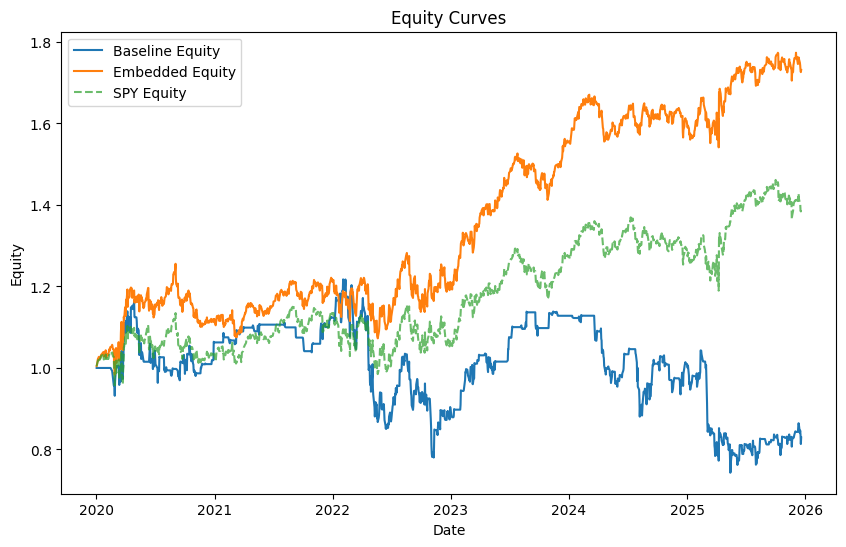

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(out["baseline"]["equity"], label="Baseline Equity")
plt.plot(out["embedded"]["equity"], label="Embedded Equity")
plt.plot(out["spy_eq"], label="SPY Equity", linestyle="--", alpha=0.7)
plt.legend()
plt.title("Equity Curves")
plt.xlabel("Date")
plt.ylabel("Equity")
plt.show()

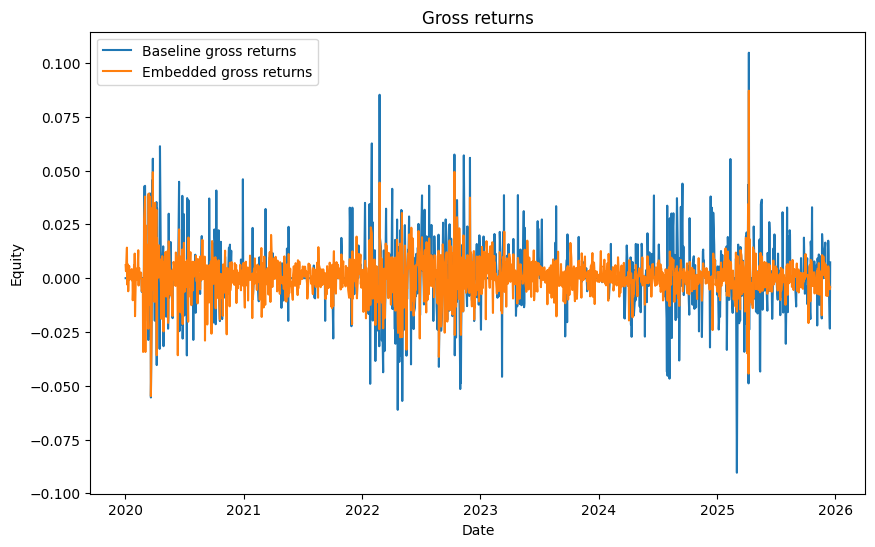

In [28]:
plt.figure(figsize=(10,6))
plt.plot(out["baseline"]["gross"], label="Baseline gross returns")
plt.plot(out["embedded"]["gross"], label="Embedded gross returns")
plt.legend()
plt.title("Gross returns")
plt.xlabel("Date")
plt.ylabel("Equity")
plt.show()

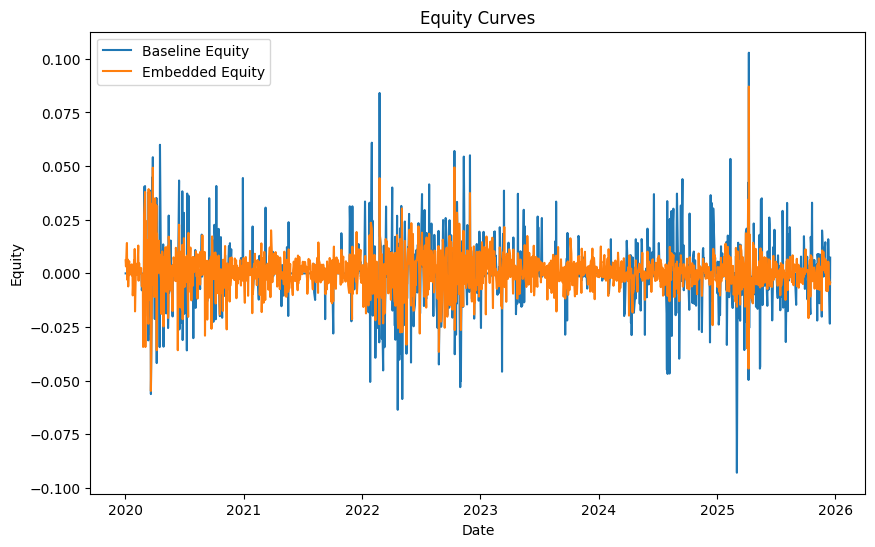

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(out["baseline"]["net"], label="Baseline net returns")
plt.plot(out["embedded"]["net"], label="Embedded net returns")
plt.legend()
plt.title("Equity Curves")
plt.xlabel("Date")
plt.ylabel("Equity")
plt.show()

In [36]:
print("Baseline sharpe - gross returns:", perf_summary(out["baseline"]["gross"])["Sharpe"])
print("Embedded sharpe - gross returns:", perf_summary(out["embedded"]["gross"])["Sharpe"])

print("Baseline sharpe - net returns:", perf_summary(out["baseline"]["net"])["Sharpe"])
print("Embedded sharpe - net returns:", perf_summary(out["embedded"]["net"])["Sharpe"])

Baseline sharpe - gross returns: 0.6879115084700576
Embedded sharpe - gross returns: 0.7214110716828996
Baseline sharpe - net returns: -0.01640155432884119
Embedded sharpe - net returns: 0.6994331171978165


In [37]:
print("Baseline maxDD - gross returns:", perf_summary(out["baseline"]["gross"])["MaxDD"])
print("Embedded maxDD - gross returns:", perf_summary(out["embedded"]["gross"])["MaxDD"])

print("Baseline maxDD - net returns:", perf_summary(out["baseline"]["net"])["MaxDD"])
print("Embedded maxDD - net returns:", perf_summary(out["embedded"]["net"])["MaxDD"])

Baseline maxDD - gross returns: -0.24085652275767389
Embedded maxDD - gross returns: -0.14251983881191277
Baseline maxDD - net returns: -0.3897093143061682
Embedded maxDD - net returns: -0.14568536631082885


In [38]:
perf_summary(out["baseline"]["gross"])

{'CAGR': 0.1356340037433541,
 'Sharpe': 0.6879115084700576,
 'MaxDD': -0.24085652275767389,
 'AvgDailyTurnover': 1.0}

In [39]:
def alpha_beta(strat_rets, mkt_rets):
    x = mkt_rets.align(strat_rets, join="inner")[0].values
    y = strat_rets.align(mkt_rets, join="inner")[0].values
    X = np.column_stack([np.ones_like(x), x])
    # OLS
    b = np.linalg.lstsq(X, y, rcond=None)[0]
    alpha, beta = b[0], b[1]
    # t-stat alpha
    resid = y - X @ b
    s2 = (resid @ resid) / (len(y) - 2)
    var_b = s2 * np.linalg.inv(X.T @ X)
    se_alpha = np.sqrt(var_b[0,0])
    t_alpha = alpha / (se_alpha + 1e-12)
    return alpha, beta, t_alpha

alpha_e, beta_e, t_e = alpha_beta(out["embedded"]["net"], out["spy_rets"])
alpha_b, beta_b, t_b = alpha_beta(out["baseline"]["net"], out["spy_rets"])

print("Embedded alpha/day, beta, t(alpha):", alpha_e, beta_e, t_e)
print("Baseline alpha/day, beta, t(alpha):", alpha_b, beta_b, t_b)
print("Embedded alpha/yr approx:", alpha_e * 252)


Embedded alpha/day, beta, t(alpha): 0.0001592064908867382 0.9420594904362422 2.4064189731680847
Baseline alpha/day, beta, t(alpha): -0.0002585076003238336 0.8947807573140921 -0.9210463826867152
Embedded alpha/yr approx: 0.040120035703458026


In [5]:
# Top 10 holdings on a specific day
day = out["embedded"]["holdings"]["date"].max()
(out["embedded"]["holdings"]
 .query("date == @day")
 .sort_values("weight", ascending=False))


,date,ticker,weight,pred,ret
44989,2025-12-19,AAPL,0.034483,0.017243,0.005585
45004,2025-12-19,PG,0.034483,0.021082,-0.007216
45016,2025-12-19,INTC,0.034483,0.022105,0.009320
45015,2025-12-19,ABT,0.034483,0.021262,0.003279
45014,2025-12-19,TMO,0.034483,0.014687,0.010949
45013,2025-12-19,MCD,0.034483,0.023492,-0.008974
45012,2025-12-19,CSCO,0.034483,0.018374,0.018838
45011,2025-12-19,WMT,0.034483,0.023587,-0.006774
45010,2025-12-19,CRM,0.034483,0.027675,-0.002954
45009,2025-12-19,ADBE,0.034483,0.027976,0.000928


In [6]:
def perf_block(rets, freq=252):
    r = rets.dropna()
    ev = r.mean()
    vv = r.var(ddof=0)
    sharpe = (ev / (r.std(ddof=0) + 1e-12)) * np.sqrt(freq)
    eq = (1+r).cumprod()
    mdd = (eq/eq.cummax()-1).min()
    cagr = eq.iloc[-1]**(freq/len(r)) - 1
    return {"E_daily": float(ev), "V_daily": float(vv), "Sharpe": float(sharpe), "CAGR": float(cagr), "MaxDD": float(mdd)}

def rolling_alpha_beta(strat, mkt, window=252):
    df = pd.concat([strat, mkt], axis=1, join="inner")
    df.columns = ["s", "m"]
    alphas, betas = [], []
    idx = []

    for i in range(window, len(df)+1):
        sub = df.iloc[i-window:i]
        x = sub["m"].values
        y = sub["s"].values
        X = np.column_stack([np.ones_like(x), x])
        b = np.linalg.lstsq(X, y, rcond=None)[0]
        alpha, beta = b[0], b[1]
        idx.append(sub.index[-1])
        alphas.append(alpha * 252)   # annualize
        betas.append(beta)

    return pd.Series(alphas, index=idx, name="alpha_rolling_yr"), pd.Series(betas, index=idx, name="beta_rolling")

alpha_roll, beta_roll = rolling_alpha_beta(out["embedded"]["net"], out["spy_rets"], window=252)


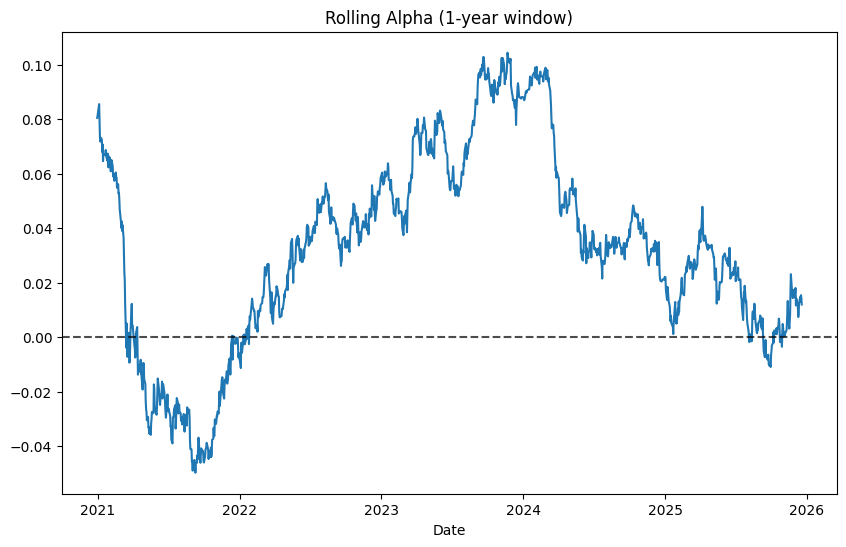

In [9]:
plt.figure(figsize=(10,6))
plt.plot(alpha_roll, label="Rolling Alpha (yr)")
plt.axhline(0, color="black", linestyle="--", alpha=0.7)
plt.title("Rolling Alpha (1-year window)")  
plt.xlabel("Date")
plt.show()  

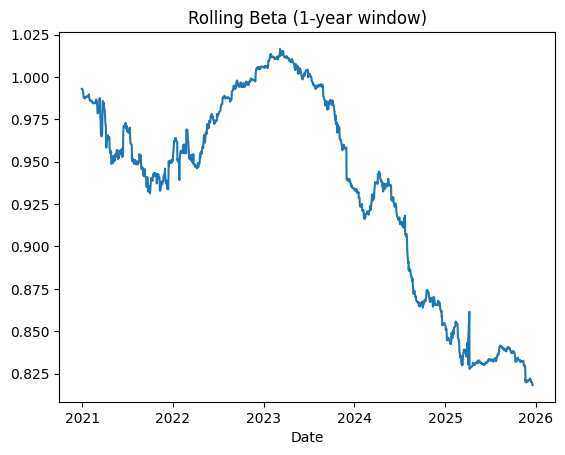

In [10]:
plt.Figure(figsize=(10,6))
plt.plot(beta_roll, label="Rolling Beta")   
plt.title("Rolling Beta (1-year window)")
plt.xlabel("Date")
plt.show()
